In [1]:
import mosek
print("MOSEK is successfully installed!")


MOSEK is successfully installed!


In [2]:
import cvxpy as cp

x = cp.Variable()
prob = cp.Problem(cp.Minimize(x**2), [x >= 1])
result = prob.solve(solver=cp.MOSEK)
print("Optimal value:", result)


Optimal value: 1.0000000137609035


In [23]:
import numpy as np

phi_uy = np.array([[9, 0],[0, 8]])

phi_ux = np.array([[2, 5, 0, 0],[0, 0, 9, 1]])
phi_xx = np.array([[1, 4, 0, 0],[2, 0, 0, 0], [0,0,9,6],[0,0,1,5]])
phi_xy = np.array([[2, 0],[1.5, 0],[0, 1],[0, 6]])

phi_xx_inv = np.linalg.inv(phi_xx)

K = phi_uy - phi_ux @ phi_xx_inv @ phi_xy
print(phi_uy)
print(K)

[[9 0]
 [0 8]]
[[ 5.9375      0.        ]
 [ 0.         13.79487179]]


In [24]:
zero_matrix = np.zeros_like(phi_xx)
phi_xx_extend = np.block([[phi_xx, zero_matrix],[phi_xx, phi_xx]])
zero_matrix = np.zeros_like(phi_uy)
phi_uy_extend = np.block([[phi_uy, zero_matrix],[phi_uy, phi_uy]])
zero_matrix = np.zeros_like(phi_ux)
phi_ux_extend = np.block([[phi_ux, zero_matrix],[phi_ux, phi_ux]])
zero_matrix = np.zeros_like(phi_xy)
phi_xy_extend = np.block([[phi_xy, zero_matrix],[phi_xy, phi_xy]])


phi_xx_extend_inv = np.linalg.inv(phi_xx_extend)

K_extend = phi_uy_extend - phi_ux_extend @ phi_xx_extend_inv @ phi_xy_extend
print(K_extend)

[[ 5.9375      0.          0.          0.        ]
 [ 0.         13.79487179  0.          0.        ]
 [ 5.9375      0.          5.9375      0.        ]
 [ 0.         13.79487179  0.         13.79487179]]


In [5]:
import numpy as np
import re

# 读取 txt 文件
file_path = "D:/sparks/Study/Research/2025-control/lowRankControl-main/OffdiagMatrices.txt"  # 请替换为你的实际文件路径

with open(file_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

# 解析矩阵
def extract_matrix(lines, start_marker, end_marker):
    """ 提取 txt 文件中给定标记的矩阵 """
    start_idx = None
    end_idx = None

    # 找到起始和结束索引
    for i, line in enumerate(lines):
        if start_marker in line:
            start_idx = i + 1
        elif end_marker in line and start_idx is not None:
            end_idx = i
            break

    if start_idx is None or end_idx is None:
        return None  # 如果找不到标记，返回 None

    # 提取矩阵数据
    matrix_data = []
    max_cols = 0

    for line in lines[start_idx:end_idx]:
        numbers = re.findall(r"[-+]?\d*\.\d+|[-+]?\d+", line)
        if numbers:
            row = [float(num) for num in numbers]
            matrix_data.append(row)
            max_cols = max(max_cols, len(row))  # 记录最大列数

    # 统一行的长度
    for i in range(len(matrix_data)):
        if len(matrix_data[i]) < max_cols:
            matrix_data[i] += [0.0] * (max_cols - len(matrix_data[i]))  # 用 0 补齐

    return np.array(matrix_data)

# 提取 F, L21, L12
F = extract_matrix(lines, "=== F matrix (closed-loop) ===", "===")
L21 = extract_matrix(lines, "=== L21 matrix (UAV2->UAV1) ===", "===")
L12 = extract_matrix(lines, "=== L12 matrix (UAV1->UAV2) ===", "===")

# 输出矩阵形状和示例
if F is not None:
    print("F matrix shape:", F.shape)
    print("F matrix sample:\n", F[:5, :5])

if L21 is not None:
    print("L21 matrix shape:", L21.shape)
    print("L21 matrix sample:\n", L21[:5, :5])

if L12 is not None:
    print("L12 matrix shape:", L12.shape)
    print("L12 matrix sample:\n", L12[:5, :5])


F matrix shape: (220, 9)
F matrix sample:
 [[-0.2105 -0.0358  0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.    ]]
L21 matrix shape: (66, 9)
L21 matrix sample:
 [[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


In [21]:
# %% [code]
import re
import numpy as np

def parse_matrix(matrix_str):
    """
    将形如：
        [[-0.2105 -0.0358  0.      0.   ... 0.    ]
         [-0.0048 -0.0354 -0.     -0.   ... 0.    ]
         ... ]
    的字符串转换为二维列表。
    
    说明：  
    - 矩阵中的每一行都被 [] 包围，但行内各数字之间没有逗号，仅以空白分隔。
    - 利用正则表达式先提取出所有被 [] 包围的行，再按空白拆分数字。
    """
    # 正则表达式：匹配每个由 [ 和 ] 包围的子串（不匹配内部的 [ 或 ]）
    row_strings = re.findall(r'\[([^\[\]]+)\]', matrix_str)
    matrix = []
    for row in row_strings:
        # 用 split() 按所有空白分割，过滤空字符串
        tokens = row.split()
        if tokens:  # 如果该行非空
            try:
                row_floats = [float(tok) for tok in tokens]
            except Exception as e:
                raise ValueError(f"转换行数据失败：{row}\n错误信息：{e}")
            matrix.append(row_floats)
    return matrix

def extract_matrix(text, name):
    """
    从完整文本中提取名称为 name 的矩阵，并返回 numpy 数组
    
    参数：
      text: 文件全部内容（字符串）
      name: 矩阵名称，例如 "F", "L21", "L12"
            对应标题分别为：
              "=== F matrix (closed-loop) ==="
              "=== L21 matrix (UAV2->UAV1) ==="
              "=== L12 matrix (UAV1->UAV2) ==="
    """
    # 构造正则表达式。  
    # 注意：这里使用非贪婪模式 .*? 以匹配标题后面的矩阵块。
    pattern = r"===\s*{} matrix.*?===\s*(\[\[.*?\]\])".format(name)
    match = re.search(pattern, text, re.DOTALL)
    if not match:
        raise ValueError(f"未找到矩阵 {name} 的匹配项")
    matrix_str = match.group(1)
    # 用自定义的 parse_matrix 解析字符串（不能直接用 ast.literal_eval）
    matrix_list = parse_matrix(matrix_str)
    return np.array(matrix_list)

# %% [code]
# 读取 txt 文件（请调整文件路径和编码，如有需要）
file_path = "D:/sparks/Study/Research/2025-control/lowRankControl-main/OffdiagMatrices.txt"  # 请替换为你的实际文件路径
with open(file_path, "r", encoding="utf-8") as f:
    content = f.read()

# 分别提取 F, L21, L12 三个矩阵
F   = extract_matrix(content, "F")
L21 = extract_matrix(content, "L21")
L12 = extract_matrix(content, "L12")

# 查看提取出的矩阵形状及部分数据
print("F 矩阵形状:", F.shape)
print("L21 矩阵形状:", L21.shape)
print("L12 矩阵形状:", L12.shape)

print("\nF 矩阵前两行：\n", F[:2])


F 矩阵形状: (44, 44)
L21 矩阵形状: (22, 22)
L12 矩阵形状: (22, 22)

F 矩阵前两行：
 [[-2.10480552e-01 -3.58100687e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.78769850e-03 -3.54280157e-02 -6.00000000e-10 -6.00000000e-10
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.0000

In [22]:
rank_F   = np.linalg.matrix_rank(F, tol=1e-7)
rank_L21 = np.linalg.matrix_rank(L21, tol=1e-7)
rank_L12 = np.linalg.matrix_rank(L12, tol=1e-7)

print("F 矩阵的秩:", rank_F)
print("L21 矩阵的秩:", rank_L21)
print("L12 矩阵的秩:", rank_L12)


F 矩阵的秩: 39
L21 矩阵的秩: 1
L12 矩阵的秩: 1


原始 8×8 矩阵 F：
[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]] 

结果 (direction='21'):
[[ 1.  3.  5.  7.]
 [ 9. 11. 13. 15.]
 [33. 35. 37. 39.]
 [41. 43. 45. 47.]] 

结果 (direction='12'):
[[16. 18. 20. 22.]
 [24. 26. 28. 30.]
 [48. 50. 52. 54.]
 [56. 58. 60. 62.]]


In [2]:
import numpy as np

# 定义一个简单的类，用来容纳属性 self.T 与矩阵 self.F
class Example:
    def __init__(self, T):
        self.T = T
        # 这里创建一个 8×8 的简单测试矩阵，元素 0~63
        # 当 T=1 时， 4*(T+1) = 8，恰好是个 8×8
        self.F = np.arange(64).reshape(8, 8)
    
    def extract_mutral_detection_communication_matrix(self, direction='21'):
        Tplus1 = self.T + 1
        block_row = 4
        block_col = 4
        
        # 最终 big_mat 的大小是 2*(T+1) 行 × 2*(T+1) 列
        big_mat = np.zeros((2*Tplus1, 2*Tplus1))

        for t in range(Tplus1):
            for tau in range(Tplus1):
                row_start = t * block_row
                col_start = tau * block_col

                # 取出 4×4 分块
                sub_4x4 = self.F[row_start : row_start + block_row,
                                  col_start : col_start + block_col]

                # direction == '21' -> L1 索引: 行 [0,1], 列 [1,3]
                # direction == '12' -> L2 索引: 行 [2,3], 列 [0,2]
                if direction == '21':
                    sub_2x2 = sub_4x4[np.ix_([0,1], [1,3])]
                else:  # direction == '12'
                    sub_2x2 = sub_4x4[np.ix_([2,3], [0,2])]

                # 拼装进 big_mat
                big_mat[t*2 : (t+1)*2, tau*2 : (tau+1)*2] = sub_2x2
        
        return big_mat

# 创建一个 T=1 的示例实例
ex = Example(T=1)

print("原始 8×8 矩阵 F：")
print(ex.F, "\n")

# direction='21' 的结果
out21 = ex.extract_mutral_detection_communication_matrix(direction='21')
print("结果 (direction='21'):")
print(out21, "\n")

# direction='12' 的结果
out12 = ex.extract_mutral_detection_communication_matrix(direction='12')
print("结果 (direction='12'):")
print(out12)


原始 8×8 矩阵 F：
[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]] 

结果 (direction='21'):
[[ 1.  3.  5.  7.]
 [ 9. 11. 13. 15.]
 [33. 35. 37. 39.]
 [41. 43. 45. 47.]] 

结果 (direction='12'):
[[16. 18. 20. 22.]
 [24. 26. 28. 30.]
 [48. 50. 52. 54.]
 [56. 58. 60. 62.]]


In [1]:
import numpy as np
sub_2x4 = np.arange(8).reshape(2,4)  # 创建一个 2x4 矩阵
sub_1x2 = sub_2x4[1:2, 0:2]  # 取第二行的前两列
print(sub_1x2.shape)  # 输出 (1, 2)
print(sub_1x2)  # 查看结果


(1, 2)
[[4 5]]


In [2]:
import numpy as np

def row_factorization(M, rank_eps=1e-7):
    m, n = M.shape
    rank_M = np.linalg.matrix_rank(M, tol=rank_eps)

    E = np.zeros((0, n))
    D = np.zeros((0, 0))

    rank_counter = 0
    rank_increase_rows = [None]*rank_M

    for row in range(m):
        submat_new = M[:row+1, :]
        rank_new = np.linalg.matrix_rank(submat_new, tol=rank_eps)

        if rank_new - rank_counter == 1:
            rank_increase_rows[rank_counter] = row
            rank_counter += 1

            E = np.vstack([E, submat_new[row:row+1, :]])
            if D.shape[1] < rank_counter:
                D = np.hstack([D, np.zeros((D.shape[0], 1))])

            unit = np.zeros((1, rank_counter))
            unit[0, -1] = 1.0
            D = np.vstack([D, unit])

        elif rank_new == rank_counter:
            c, _, _, _ = np.linalg.lstsq(E.T, M[row, :], rcond=None)
            c = c.reshape(1, rank_counter)  # (1, rank_counter)
            D = np.vstack([D, c])
        else:
            raise ValueError("Rank increased by more than 1 at row {}.".format(row))

    assert E.shape == (rank_counter, n)
    assert D.shape == (m, rank_counter)
    assert rank_counter == rank_M

    return D, E, rank_increase_rows

def check_factorization(M, D, E, tol=1e-7):
    """返回True/False并打印误差信息"""
    M_hat = D @ E
    diff = np.linalg.norm(M - M_hat, ord='fro')
    if diff < tol:
        return True, diff
    else:
        return False, diff


def test_example(M, name="", rank_eps=1e-7):
    """对给定矩阵M执行row_factorization，并检查结果"""
    print(f"\n=== Test: {name} ===")
    print("M =\n", M)
    print("Shape of M =", M.shape)

    D, E, rank_increase_rows = row_factorization(M, rank_eps=rank_eps)
    print("D =\n", D)
    print("E =\n", E)
    print("rank_increase_rows =", rank_increase_rows)

    # 验证D和E的维度
    rank_M = np.linalg.matrix_rank(M, tol=rank_eps)
    print("Computed rank of M =", rank_M)
    print("D shape =", D.shape, "E shape =", E.shape)

    # 验证 M ≈ D @ E
    ok, diff = check_factorization(M, D, E)
    print(f"||M - D@E||_F = {diff:.6g}")
    print("Factorization correct within tolerance?" , ok)


if __name__ == "__main__":

    # 1) 测试：单位矩阵
    M1 = np.eye(4)
    test_example(M1, name="Identity 4x4")

    # 2) 测试：简单重复行
    # 行3是行0的两倍，行4是行1+行2的和
    M2 = np.array([
        [1, 2, 3],
        [0, 1, 1],
        [2, 3, 4],
        [2, 4, 6],  # row0 的 2倍
        [2, 4, 5],  # row1+row2 - row0
    ], dtype=float)
    test_example(M2, name="Matrix with repeated/dep. rows")

    # 3) 测试：随机矩阵（保证 rank < min(m,n)）
    # 比如先生成一个 5x2，再让其中1列是另一列的线性组合，故秩至多1
    np.random.seed(42)
    vec = np.random.randn(5,1)
    M3 = np.hstack([vec, 3*vec])  # rank=1
    test_example(M3, name="Rank=1 random 5x2")

    # 4) 测试：完整随机，但尺寸较小
    # 可能是满秩，也可能不是，看随机结果
    M4 = np.random.randn(5, 5)   # 5x5
    test_example(M4, name="Random 5x5")

    # 5) 测试：人为构造 rank=2 的方阵
    M5 = np.array([
        [1, 2, 3, 4],
        [2, 4, 6, 8],
        [0, 1, 1, 2],
        [1, 3, 4, 7]
    ], dtype=float)
    # 其中前两行线性相关，第3行独立，第4行可能与前几行无关(需要检查)
    test_example(M5, name="Constructed rank=2 matrix")



=== Test: Identity 4x4 ===
M =
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Shape of M = (4, 4)
D =
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
E =
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
rank_increase_rows = [0, 1, 2, 3]
Computed rank of M = 4
D shape = (4, 4) E shape = (4, 4)
||M - D@E||_F = 0
Factorization correct within tolerance? True

=== Test: Matrix with repeated/dep. rows ===
M =
 [[1. 2. 3.]
 [0. 1. 1.]
 [2. 3. 4.]
 [2. 4. 6.]
 [2. 4. 5.]]
Shape of M = (5, 3)
D =
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 2.00000000e+00 -1.76986184e-15  2.13851239e-15]
 [-1.97227106e-16  1.00000000e+00  1.00000000e+00]]
E =
 [[1. 2. 3.]
 [0. 1. 1.]
 [2. 3. 4.]]
rank_increase_rows = [0, 1, 2]
Computed rank of M = 3
D shape = (5, 3) E shape = (3, 3)
||M - D@E||_F = 3.47555e-15
Factorization correct within tolerance? True

===

Files in npz: ['L21', 'L21_D', 'L21_E', 'L21_times', 'L12', 'L12_D', 'L12_E', 'L12_times', 'L21_Phiuy', 'L21_PhiuyD', 'L21_PhiuyE', 'L21_Phiuy_times', 'L21_Phiux', 'L21_PhiuxD', 'L21_PhiuxE', 'L21_Phiux_times', 'L21_Phixy', 'L21_PhixyD', 'L21_PhixyE', 'L21_Phixy_times', 'L12_Phiuy', 'L12_PhiuyD', 'L12_PhiuyE', 'L12_Phiuy_times', 'L12_Phiux', 'L12_PhiuxD', 'L12_PhiuxE', 'L12_Phiux_times', 'L12_Phixy', 'L12_PhixyD', 'L12_PhixyE', 'L12_Phixy_times']


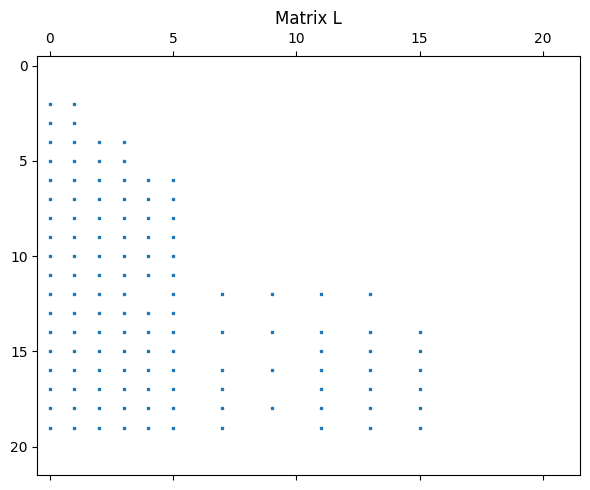

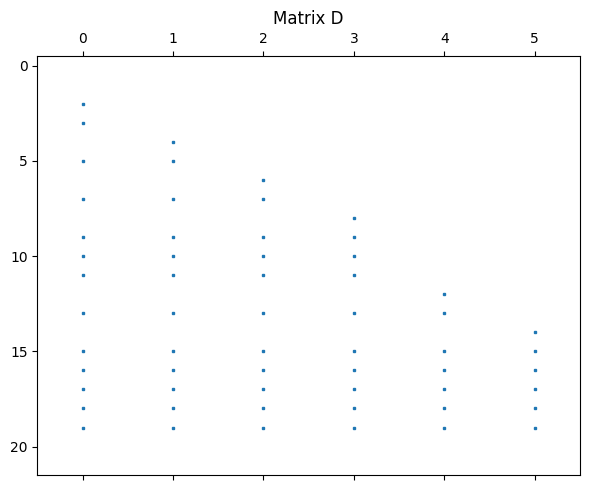

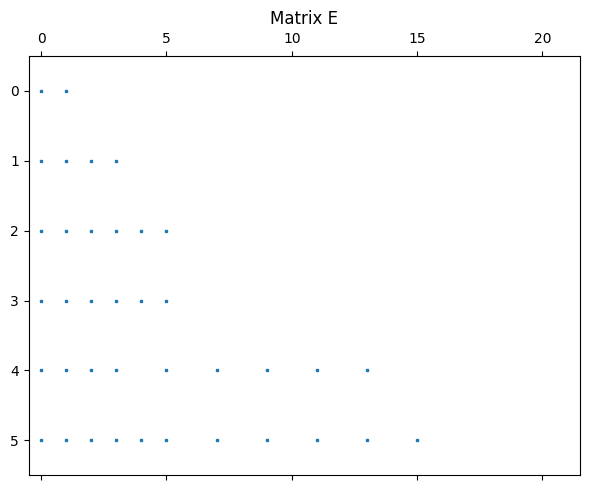

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 载入 npz 文件
data = np.load("SLS_offdiag_results.npz", allow_pickle=True)

# 2. 查看里面存了哪些数组(键)
print("Files in npz:", data.files)

# 假设其中有 'L', 'D', 'E' 三个键；可根据实际情况修改！
L = data['L12']  # 例如: (m, n) 矩阵
D = data['L12_D']  # 例如: (m, r) 矩阵
E = data['L12_E']  # 例如: (r, n) 矩阵

# 3. 画图函数：用 plt.spy() 来显示非零位置
def plot_matrix_spy(mat, title="", precision=1e-7):
    plt.figure(figsize=(6, 5))
    plt.spy(mat, precision=precision, markersize=2, aspect='auto')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 4. 分别可视化 L, D, E
plot_matrix_spy(L, "Matrix L")
plot_matrix_spy(D, "Matrix D")
plot_matrix_spy(E, "Matrix E")

# 如果你想把非零元素用更严格或宽松阈值，可以调 precision=...
# 如果你想要“蓝色点”，还可以设置 cmap 等高级参数：
#   plt.spy(mat, precision=1e-12, markersize=2, aspect='auto', c='blue')


In [20]:
print("L rank: ",np.linalg.matrix_rank(L, tol=10e-7))
print("D rank: ",np.linalg.matrix_rank(D, tol=10e-7))
print("E rank: ",np.linalg.matrix_rank(E, tol=10e-7))


L rank:  6
D rank:  6
E rank:  6


Files in npz: ['L21', 'L21_D', 'L21_E', 'L21_times', 'L12', 'L12_D', 'L12_E', 'L12_times', 'L21_Phiuy', 'L21_PhiuyD', 'L21_PhiuyE', 'L21_Phiuy_times', 'L21_Phiux', 'L21_PhiuxD', 'L21_PhiuxE', 'L21_Phiux_times', 'L21_Phixy', 'L21_PhixyD', 'L21_PhixyE', 'L21_Phixy_times', 'L12_Phiuy', 'L12_PhiuyD', 'L12_PhiuyE', 'L12_Phiuy_times', 'L12_Phiux', 'L12_PhiuxD', 'L12_PhiuxE', 'L12_Phiux_times', 'L12_Phixy', 'L12_PhixyD', 'L12_PhixyE', 'L12_Phixy_times']
Rank of L_test: 12

D_test shape: (22, 12)
E_test shape: (12, 22)
Times with rank increase: [2, 4, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18]
Reconstruction error: 9.790510393739282e-10


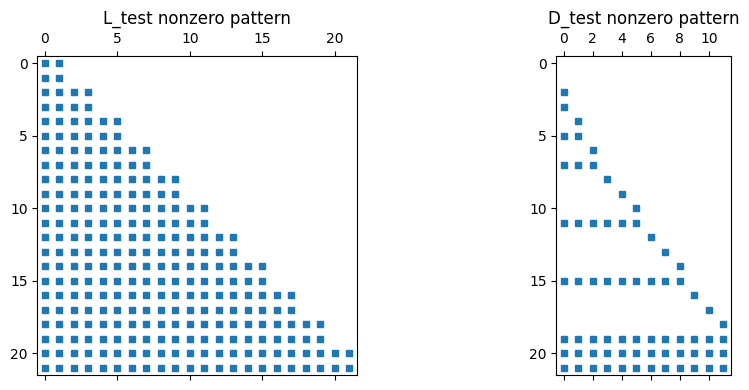

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def row_factorization_causal(L, rank_eps=1e-7):
    """
    因果式行分解: 只要输入矩阵 L 和 rank_eps, 默认从第 0 行到第 (m-1) 行
    依次作为“时间 0,1,2,...”。无须给 T, nu 等额外参数。

    参数:
    -------
    L : np.ndarray, shape=(m, n)
        待因子分解的矩阵, 行数 m 表示时间步数
    rank_eps : float
        用于计算秩时的阈值

    返回:
    -------
    D : np.ndarray, shape=(m, r)
    E : np.ndarray, shape=(r, n)
    rank_increase_times : list of int
        哪些行(时间)带来了新的独立方向
    """
    m, n = L.shape
    # 理论秩
    rank_L = np.linalg.matrix_rank(L, tol=rank_eps)

    # 初始化 E, D
    E = np.zeros((0, n))
    D = np.zeros((0, 0))

    rank_counter = 0
    rank_increase_times = [None]*rank_L

    # 从上到下( time=0..m-1 ) 扫描 L 的行
    for time in range(m):
        # 取到当前行为止的子矩阵
        submat_new = L[:time+1, :]
        rank_new = np.linalg.matrix_rank(submat_new, tol=rank_eps)

        if rank_new - rank_counter == 1:
            # 第 time 行带来一个新独立方向
            rank_increase_times[rank_counter] = time
            rank_counter += 1

            # 把这一行加入 E
            E = np.vstack([E, L[time:time+1, :]])
            # 确保 D 的列数=rank_counter
            if D.shape[1] < rank_counter:
                D = np.hstack([D, np.zeros((D.shape[0], 1))])

            # D 中增加一行, 该行对新方向的系数=1
            unit = np.zeros((1, rank_counter))
            unit[0, -1] = 1.0
            D = np.vstack([D, unit])

        elif rank_new == rank_counter:
            # 该行可由现有基底行线性组合
            c, _, _, _ = np.linalg.lstsq(E.T, L[time, :], rcond=None)
            c = c.reshape(1, rank_counter)
            D = np.vstack([D, c])

        else:
            raise ValueError(f"Rank increased by more than 1 at time={time}.")

    # 断言结果维度
    assert E.shape[0] == rank_counter
    assert D.shape[0] == m
    assert D.shape[1] == rank_counter
    assert rank_counter == rank_L, f"Got rank_counter={rank_counter}, but rank_L={rank_L}."

    return D, E, rank_increase_times


# ----------------------------- 测试代码示例 -----------------------------
if __name__ == "__main__":


    data = np.load("SLS_offdiag_results.npz", allow_pickle=True)

    print("Files in npz:", data.files)
    L = data['L21']  # 例如: (m, n) 矩阵
    D = data['L21_D']  # 例如: (m, r) 矩阵
    E = data['L21_E']  # 例如: (r, n) 矩阵

    L_test = L
    print("Rank of L_test:", np.linalg.matrix_rank(L_test, tol=1e-7))
    D_test, E_test, times_test = row_factorization_causal(L_test, rank_eps=1e-7)

    print("\nD_test shape:", D_test.shape)
    print("E_test shape:", E_test.shape)
    print("Times with rank increase:", times_test)

    L_recon = D_test @ E_test
    err = np.linalg.norm(L_test - L_recon, 'fro')
    print("Reconstruction error:", err)

    # 稀疏可视化
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.title("L_test nonzero pattern")
    plt.spy(L_test, markersize=5)

    plt.subplot(1,2,2)
    plt.title("D_test nonzero pattern")
    plt.spy(D_test, markersize=5)

    # plt.subplot(1,2,2)
    # plt.title("E_test nonzero pattern")
    # plt.spy(E_test, markersize=5)


    plt.tight_layout()
    plt.show()
